In [1]:
# Don't change this cell; just run it.
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

# Safe settings for Pandas.
pd.set_option('mode.chained_assignment', 'raise')
%matplotlib inline
import matplotlib.pyplot as plt

from population_sample_image_generator import *
# just some random coordinates, used in a later plot
x_coord, y_coord = np.meshgrid(np.arange(0, 1, 1/1236), np.arange(0, 1, 1/1236))
x_coord, y_coord = x_coord.flatten(), y_coord.flatten() 
random_coord_indexes = np.random.choice(len(x_coord), 1236, replace = False)
x_coord, y_coord = x_coord[random_coord_indexes], y_coord[random_coord_indexes]

# Make the plots look more fancy.
plt.style.use('fivethirtyeight')

## Confidence Intervals

- We will look at confidence intervals via a modern code-based method of generating them, called the bootsrap

- (I hope you'll agree!) this approach promotes a deep understanding of the meaning of confidence intervals 

- The information the confidence intervals convey is the same as that conveyed by confidence intervals generated by "traditional" methods (e.g. those derived from formulas you have no doubt seen in statistics textbooks)

*Note*: This page has content from the [Bootstrap](https://github.com/data-8/textbook/blob/64b20f0/notebooks/Bootstrap.ipynb)
notebook of an older version of the [UC Berkeley data science course](https://inferentialthinking.com/). See the Berkeley course section of the [license file](https://uob-ds.github.io/cfd2021/license).

## A data scientist's predicament

Consider this scenario: a data scientist has been asked to help with a research project in the field of historical epidemiology - analysing historical datasets related to health. 

Her task is to calculate the average birthweight of babies born at a small hospital in Oakland, CA in the year 1960. She is to do this in order to later test the hypothesis that babies born at this hospital in this year were underweight, relative to the national average at that time.

However, the data scientist is in a predicament.  Initially, she was granted access to a random sample of 25 baby records whilst waiting for clearance from the hospital's medical records department to access the complete dataset. The complete dataset includes the birthweights for all 1236 babies born at that hospital in 1960.

But disaster has struck, and the hospital's medical records department has been subject to a ransomware attack, and so the full dataset is inaccessible, for a indeterminate period of time. (Alas, research rarely goes to plan!).

At the moment, she only has her random sample of 25 babies, which is shown the output of the code cell below:

In [2]:
# load in the sample data (this IS real data!)
babies_sample = pd.read_csv('babies_sample.csv')

# show the sample data
babies_sample

,birthweight_kg
0,3.260195
1,3.316894
2,2.806602
3,3.401942
4,3.033399
5,3.118447
6,3.373593
7,3.685438
8,3.628739
9,3.855535


Because our data scientist is interested in the average (mean) birthweight, so she calculates this from her sample:

In [3]:
# calculate the sample mean
sample_mean = babies_sample['birthweight_kg'].mean()

# show the sample mean
sample_mean

3.4121482272

She also plots the sample birthweights, to see how they are distributed, relative to the sample average:

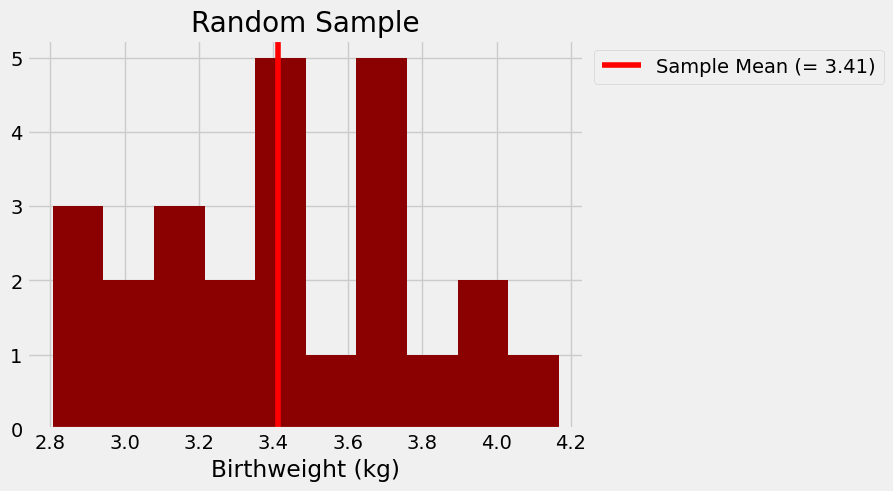

In [4]:
# plot the sample, and its mean
plt.hist(babies_sample['birthweight_kg'], color = 'darkred')
plt.axvline(sample_mean, color = 'red', label = f"Sample Mean (= {round(sample_mean, 2)})")
plt.xlabel('Birthweight (kg)')
plt.title('Random Sample')
plt.legend(bbox_to_anchor = (1,1));

As it stands, because the full dataset is inaccessible due to the ransomware attack, our data scientist is stuck with her random sample of 25 birthweights. However, she doesn't care specifically about this random sample of 25 babies; *she cares about the population of all 1236 babies born in 1960 at this particular hospital*. 

Somehow she needs to use her sample and its average birthweight to accurately estimate the population's average birthweight.

It's important to clarify the terminology used I've used here. In statistics and data science, "population" refers to all the observational units (in this case, babies) that are of interest for a specific research question. In this case, the population of interest is all 1236 babies born at the hospital in 1960.

Conversely, a "sample" is a smaller subset of the population. A *random* sample is one where each observation in the sample had an equal probability of being selected, ensuring there is no bias towards specific observations. In this case, the sample being random means that each baby had an equal chance of being selected into the sample.

![](images/pop_sample_pic.png)

(image from: https://statsandr.com/blog/what-is-the-difference-between-population-and-sample/)

Our data scientist could simply take the average birthweight of her sample and report it as the estimated population birthweight, but she knows that her random sample is just one of many possible random samples. 

On a different day, different babies' records would have made it into her random sample, and the sample's average birthweight would have been different. Consequently, when she uses the sample average as her estimate of the population birthweight, her estimate would have been different as well.

## An all-knowing perspective

To clarify our data scientist's concerns, I'd like you to imagine that WE (everyone present today) has access to the lost, full dataset. Let's imagine that there is a computer in the hospital which is not connected to the internet, and has survived the ransomware attack unscathed.

But only WE know the password to this hallowed computer, and so only WE can view the full dataset.

Here is the full dataset, containing the birthweights of all babies born in 1960 at the hospital:

In [5]:
# load in the population data
babies_pop = pd.read_csv('babies.csv')

# show the data
babies_pop

,birthweight_kg
0,3.401942
1,3.203496
2,3.628739
3,3.486991
4,3.061748
...,...
1231,3.203496
1232,3.628739
1233,3.685438
1234,3.543690


We are almost never in this situation in research - of being able to access the full population data - and so, from our luxury, all-knowing viewpoint, we can just plot the population data, and "peek" at the population mean:

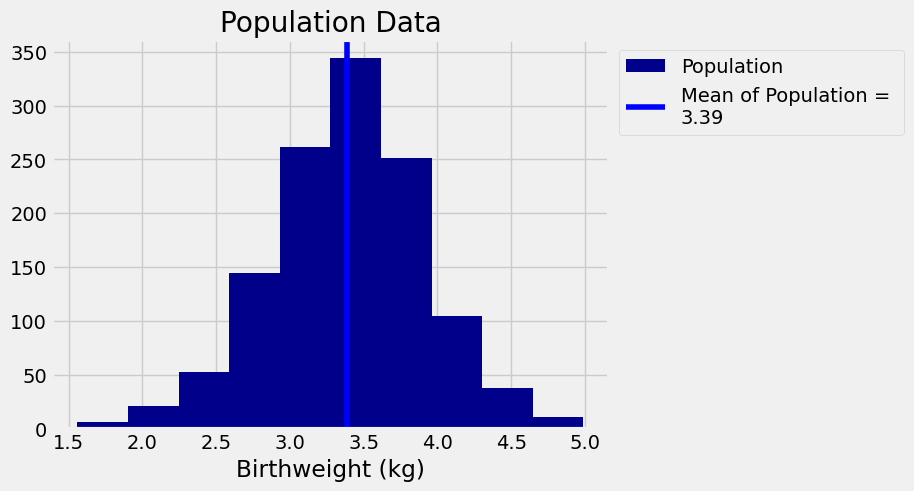

In [6]:
# plot a histogram, show the pop and pop mean
plt.hist(babies_pop["birthweight_kg"], color = 'darkblue', 
         label = 'Population')
plt.axvline(babies_pop["birthweight_kg"].mean(), 
            label = f'Mean of Population = \n{babies_pop["birthweight_kg"].mean().round(2)}', 
            color = "blue")
# add axis labels and legend
plt.xlabel('Birthweight (kg)')
plt.legend(bbox_to_anchor = (1,1))
plt.title('Population Data');

We can store the population mean as a python variable, to use later:

In [7]:
# store the population mean as a variable
population_mean = babies_pop["birthweight_kg"].mean().round(2)

# show the population mean
population_mean

3.39

Remember I said earlier that our data scientist knows that her random sample could have ended up having different babies in it? And therefore the average birthweight in her sample would have been different, and that this introduces uncertainty when she tries to use her sample average as an estimate of the population average?

Well, because we are in the seemingly all-knowing position of being able to "see" the whole population data, we can simulate the situation the data scientist is in by drawing a random sample of 25 babies from the population of 1236 babies. 

Only - because we have access to the population data - we can do this as many times as we like, so we can not only see how far off each sample average is from the actual population mean, we can also build an intuition as to how much sample averages vary as we draw lots of random samples.

The code cell below draws a random sample from the population data:

In [8]:
# draw a new sample
new_sample = babies_pop.sample(25)

# show the new sample and the mean
display(Markdown(f"\nNew sample mean = {np.mean(new_sample).round(2)}"))
display(new_sample.round(2))


New sample mean = 3.25

,birthweight_kg
1219,3.12
221,3.43
547,3.15
707,3.43
358,3.40
926,3.71
770,2.95
824,3.69
270,3.97
47,3.12


Let's draw another random sample, from our omniscient perspective, and let's plot it against the population data, so we can see graphically how close or far our sample average is from the population average.

Through running this code cell multiple times, we can build an intuition for how much the sample averages vary, over repeated samples:

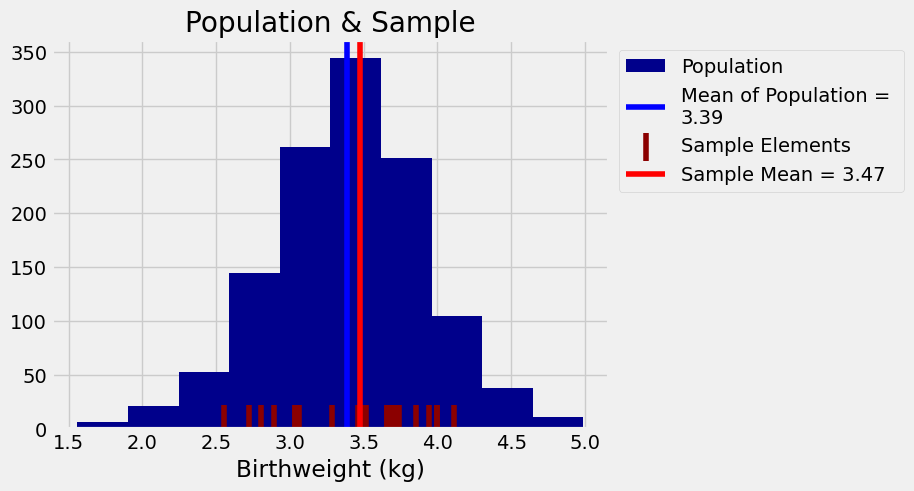

In [9]:
# draw a new random sample
sample = babies_pop["birthweight_kg"].sample(25)

# plot a histogram, show the pop and pop mean
plt.hist(babies_pop["birthweight_kg"], color = 'darkblue', 
         label = 'Population')
plt.axvline(babies_pop["birthweight_kg"].mean(), 
            label = f'Mean of Population = \n{population_mean}', 
            color = "blue")

# show the new sample and new sample mean
plt.scatter(sample, np.repeat(9, len(sample)), 
            marker = "|", s = 400, 
            color = 'darkred',
            label = 'Sample Elements')
plt.axvline(sample.mean(), color = "red",
            label = f'Sample Mean = {sample.mean().round(2)}')
    
# add axis labels and legend
plt.xlabel('Birthweight (kg)')
plt.legend(bbox_to_anchor = (1,1))
plt.title('Population & Sample');

We can see that from each sample, sometimes we get good estimates of the population mean, sometimes we get bad estimates.

Another way of showing this process is on which I like to call a "field plot" (just my name for it!). Imagine you're hovering in the sky, looking down on a field. In it are all the 1236 babies in the population are sitting in perfect lines (12 lines, with 103 babies in each). 

The graph below on the left shows these lines (viewed from above) and in the location of each baby, the birthweight of that baby is displayed. The graph on the left shows all of the birthweights for all 1236 babies.

The graph on the right shows a random sample of 25 of the baby birthweights (highlighted in red):

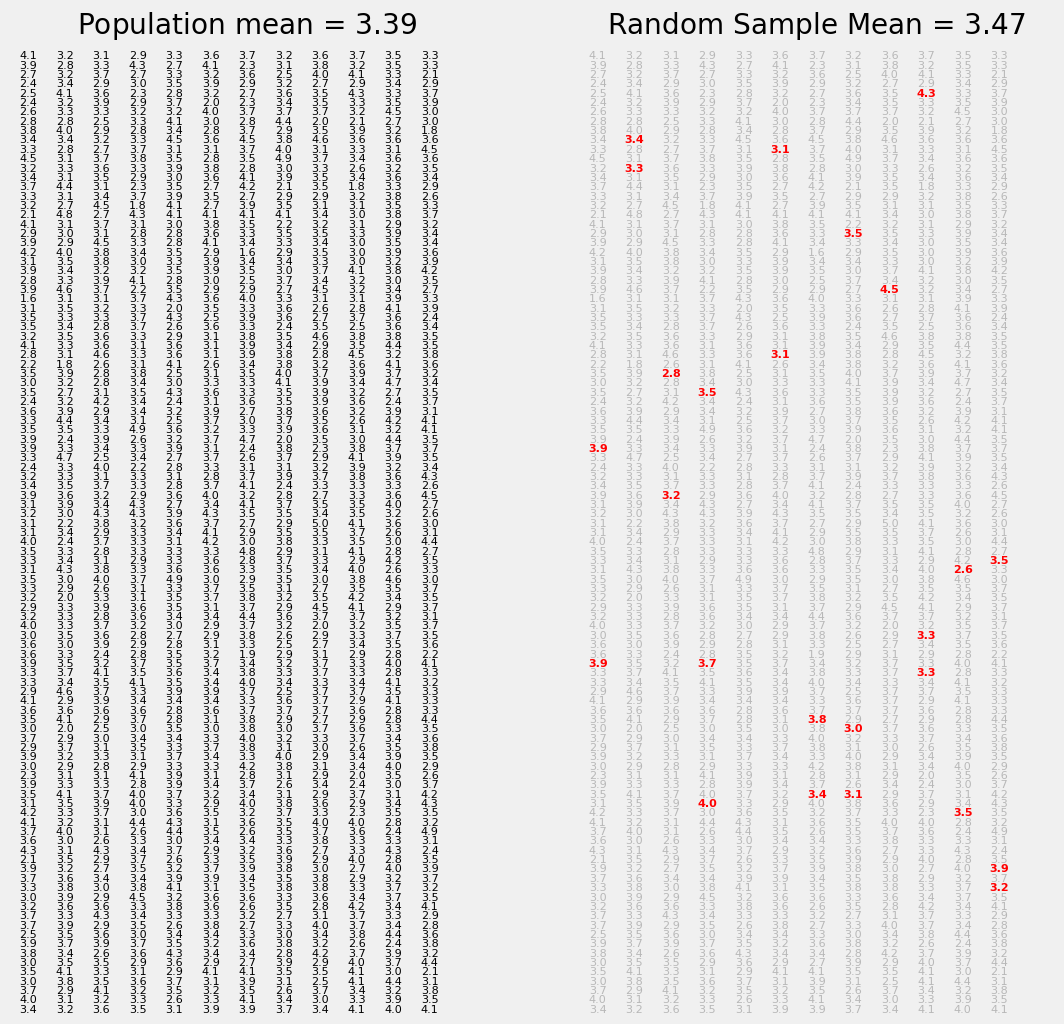

In [10]:
# this is a custom function, as the code to produce this plot is quite long...
field_plot(babies_pop, fontsize = 8, figsize = (12,12))

## Plus or minus a bit

So we have seen that sample averages do not always capture the population average.

Sometimes they are higher, sometimes they are lot lower.

Sometimes the deviation of the sample average from the population average is large, sometimes it is small.

This phenomenon is called *sampling error* - sample averages tend to deviate from the population average, even when the sample is random.

So when our data scientist is wondering whether her sample average is a good representation of the population average, she knows that the answer is "the population average is probably somewhere near my sample average, but because of sampling error it'll be the sample average **plus or minus a bit**".

This "plus or minus a bit" means her sample average is an *uncertain* estimate of the population average.

But how uncertain? How does she know how big "plus or minus a bit" might be? Our data scientist is not in the luxury, all knowing perspective we are currently in. We can simply draw new random samples to see how much, on average, their means vary. We can also "peek" at the true population mean.

Currently, two things things are hidden from her:

- The population mean itself

- The amount by which sample averages of samples of 25 babies vary from each other

If she knew the population mean, she wouldn't have to infer anything from her sample. She could just report the population mean to the rest of her reserch team.

But, even if she doesn't know the true population mean, if she knew the amount by which sample averages vary - over repeated random sampling of the sort we've just seen in the code cells above - she could use that information to construct an *interval* in which the population mean probably lies. This is a *confidence interval*.

She can't do draw new random samples from the population - but we from our luxury perspective can:

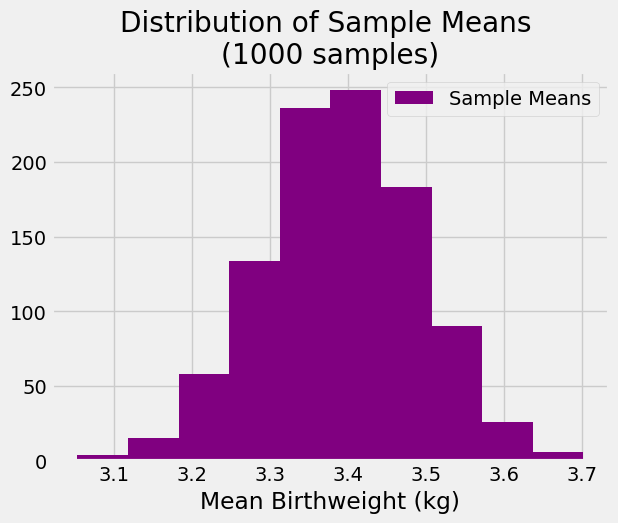

In [11]:
# set how many samples to draw
number_of_samples = 1000

# an empty array to store the sample means
sample_means = np.empty(number_of_samples)

# draw 1000 random samples of size 25 from the population data
# and store the mean of each sample in the `sample_means` array
for i in np.arange(1000):
    
    current_sample = babies_pop["birthweight_kg"].sample(25)
    
    sample_means[i] = current_sample.mean()
    
plt.hist(sample_means, color = 'purple', label = 'Sample Means')
plt.legend(bbox_to_anchor = (1, 1))
plt.xlabel('Mean Birthweight (kg)')
plt.title(f'Distribution of Sample Means \n({number_of_samples} samples)');

Let's just recap what we've done here: because we have the population data, we've been able to draw repeated random samples from it.

We've drawn 1000 random samples, and calculated the mean for each one.

The purple histogram above shows the distribution of the means of these 1000 samples.

This histogram can let us quantify the "plus or minus a bit" I mentioned earlier - it shows us how much sample averages tend to vary from each other.

Now, if we take the "spread" of this sampling distribution, we can construct an interval which quantifies "plus or minus a bit":

In [12]:
left, right = np.percentile(sample_means, [2.5, 97.5])
print('Left:', left)
print('Right:', right)

Left: 3.1909936216799992
Right: 3.5788717543199997


We now have the middle 95% of the sample means, obtained via our all-knowing perspective of being able to repeatedly draw new samples and calculate their means:

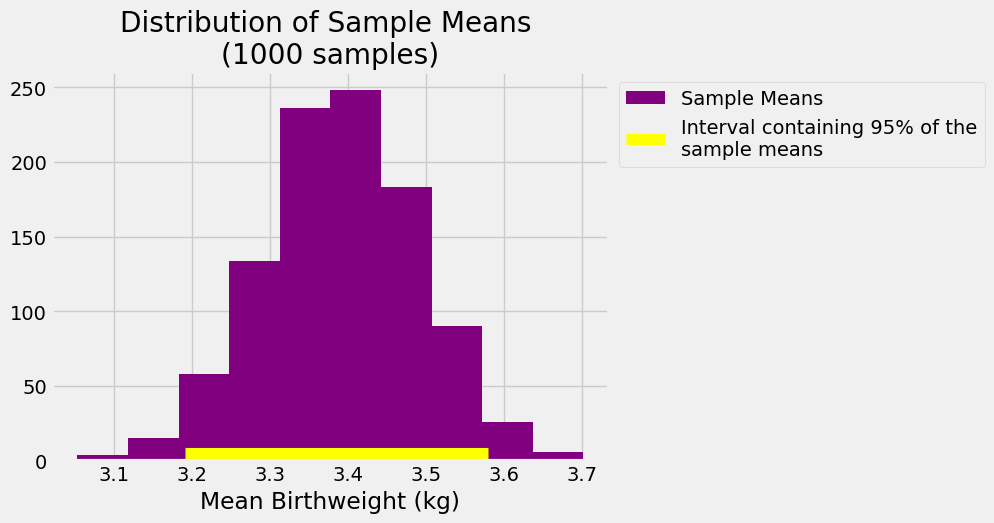

In [13]:
# plot the sampling distribution and the 95% interval
plt.hist(sample_means, color = 'purple', label = 'Sample Means')
plt.plot([left, right], [5, 5], color='yellow', lw=8, zorder=1,
         label = "Interval containing 95% of the\nsample means")
plt.legend(bbox_to_anchor = (1, 1))
plt.xlabel('Mean Birthweight (kg)')
plt.title(f'Distribution of Sample Means \n({number_of_samples} samples)');

Let's calculate how "wide" the interval is - that tells us precisely what "plus or minus a bit is", as it tells us how much the sample means typically vary from each other, as we draw lots of random samples:

In [14]:
# calculate the width of the interval
width_of_interval = right - left

# show the width of the interval
width_of_interval 

0.3878781326400005

What can we do with this interval?

The code cell below draws a new random sample and shows its mean.

It uses the "spread" of the sampling distribution - which we just calculated - and "places" the spread as an interval around the new sample mean.

If we re-run the cell lots of times, we can see that a very high proportion of the time, the yellow interval contains the population mean:

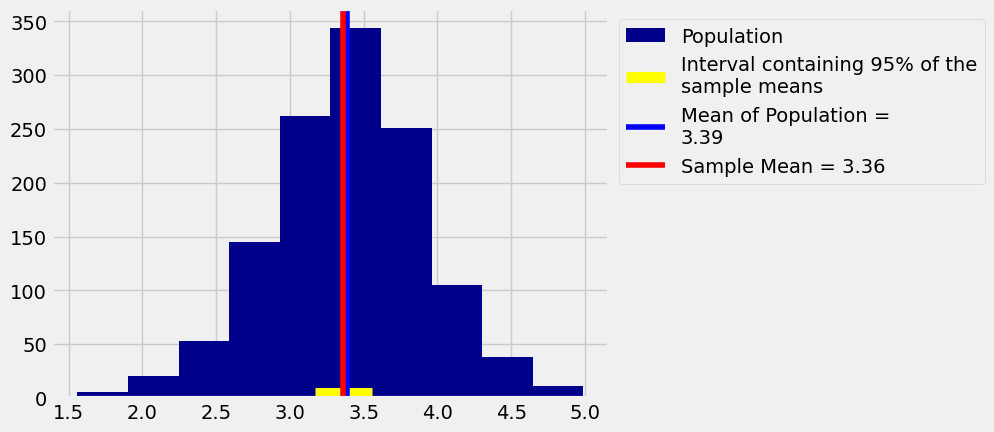

In [15]:
# draw a new random sample
sample = babies_pop["birthweight_kg"].sample(25)

# plot the population histogram
plt.hist(babies_pop["birthweight_kg"], color = 'darkblue', 
         label = 'Population')

# plot the confidence interval
plt.plot([sample.mean() - width_of_interval /2, sample.mean() + width_of_interval /2], [5, 5],
         color='yellow', lw=8, zorder=1,
         label = "Interval containing 95% of the\nsample means")

# plot the population mean
plt.axvline(babies_pop["birthweight_kg"].mean(), 
            label = f'Mean of Population = \n{population_mean}', 
            color = "blue")

# plot the sample mean
plt.axvline(sample.mean(), color = "red",
            label = f'Sample Mean = {sample.mean().round(2)}')

plt.legend(bbox_to_anchor = (1, 1));

You can see that the interval we obtained from the sampling distribution contains the population mean a big proportion of the time, even when the sample mean deviates from the population mean.

The cell below repeats the code from the cell above 100 times (apart from the graphs!), and it shows the proportion of times over all 1000 repeats that the interval around the sample mean contained the population mean.

In [16]:
# set the number of repeats
number_of_repeats = 10000

# an empty array, to record whether the interval contained
# the population mean, on each repeat
contains_population_mean = np.empty(number_of_repeats)

# on each repeat...
for i in np.arange(number_of_repeats):
    
    # draw a new sample
    current_sample = babies_pop["birthweight_kg"].sample(25)
    
    # calculate the confidence interval, from the spread of the sampling 
    # distribution
    left_end_of_interval = current_sample.mean() - width_of_interval /2
    right_end_of_interval = current_sample.mean() + width_of_interval /2
    
    # work out if the interval contains the population mean
    contains_population_mean[i] = np.logical_and(left_end_of_interval < population_mean, right_end_of_interval > population_mean)

# display the percentage of repeats where the interval contained the population mean
display(Markdown(f"{sum(contains_population_mean)/number_of_repeats * 100}% of the intervals contained the population mean."))

94.05% of the intervals contained the population mean.

This is meaning of a confidence interval.

*But* - and this is a huge but - we obtained our confidence interval only because we are in the godlike position of being able to access the whole population data, and so we were able to build our confidence interval by repeatedly drawing random samples from the population. This told us how much the means of random samples typically vary from each other, and we used that spread to construct our confidence interval.

Our data scientist cannot do this - she cannot draw new random samples from the population data she cannot access. So what is she to do?

# The Bootstrap

We've just seen that - even if we don't know the true population mean - if we can draw multiple random samples from the population, we can build a confidence interval, within which the population mean probably lies.

But typically we - and our data scientist! - cannot simply draw more random samples from the population. We're limited to the one sample we have.

Somehow, she has to get lots of new random samples without being able to draw any new random samples from the population. This seems like an impossible situation.

Fortunately, a brilliant idea called the bootstrap can help her out here. The bootstrap let's us simulate drawing new random samples by a method called *resampling*: the new samples are drawn at random *from the original sample*.

*This may seem like a sleight of hand, but hopefully I can convince you it works!*

We will now see how and why the bootstrap works. 

## The Bootstrap: Resampling from the Sample

Here are the steps of *the bootstrap method* for simulating the process of drawing new random
samples from the population:

- **Treat the original sample as if it were the population.**
- **Draw from the sample -the same size as the original sample -**, at random **with** replacement.

So let's just break that down: to get our new sample - I'll refer to this as a "bootstrap resample" - we select a baby at random from our original sample and record their birthweight. We then put that baby's record back in with the other records in the sample and then draw again at random. We do this until we have a new sample of 25 birthweights.

It is important that the bootstrap resample is the same size as the original sample
size. The reason is that the how much random sample means vary from each other depends on the size of
the sample. 

Since our original sample consisted of 25 babies, our sample
mean was based on 25 babies. To see how different the sample could have
been, we have to compare it to the mean of other samples of size 25.

#### Why do we resample WITH replacement?

If we drew 25 times at random *without* replacement from our sample of size
25, we would just get the same sample back.

By drawing *with* replacement, we
create the possibility for the new samples to be different from the original,
because some employees might be drawn more than once and others not at all.

Why is this a good idea? On average, if a sample is random, then the distribution of the
sample is likely to resemble the distribution of the population. The distributions of all the "resamples" are likely to resemble the original sample. So the distributions of all the resamples are likely to resemble the population as well.

You can remember this by the principle that **random samples tend to resemble the population...so random bootstrap resamples of the sample tend to resemble the population as well**.

![](images/bootstrap_pic.png)

## A Resampled mean

To get a bootstrap resample, we want a sample the same size as the original sample (25 babies), where we are
sampling *with replacement*. 

Here is one new sample drawn from the original sample, with replacement, and
the corresponding sample mean.

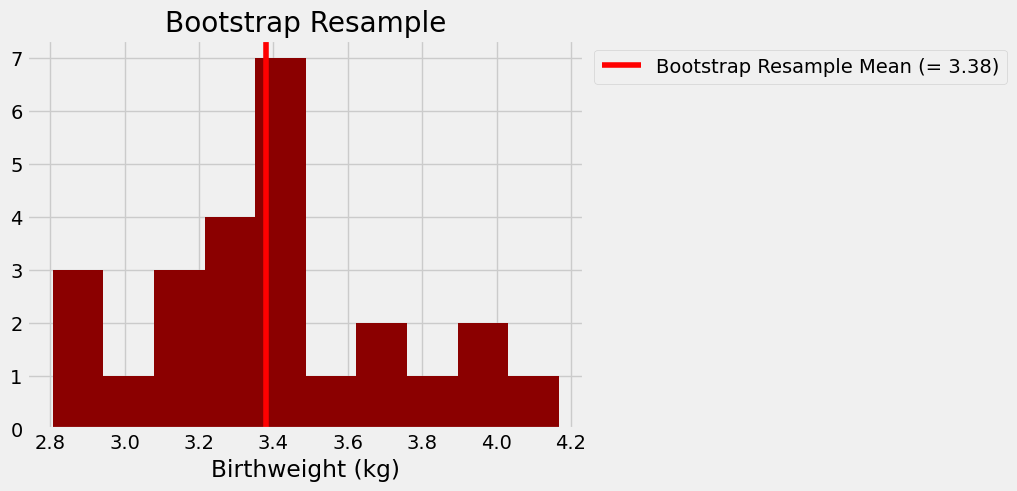

In [17]:
# draw a sample of size 25 from our original sample, with replacement.
bootstrap_resample = babies_sample['birthweight_kg'].sample(25, replace= True)

# plot a histogram of the sample
plt.hist(bootstrap_resample, color = 'darkred')
plt.axvline(bootstrap_resample.mean().round(2),
            color = 'red',
            label = f"Bootstrap Resample Mean (= {bootstrap_resample.mean().round(2)})")
plt.xlabel('Birthweight (kg)')
plt.title('Bootstrap Resample')
plt.legend(bbox_to_anchor = (1,1));

By resampling, we have something like a new sample mean with which estimate of the population
mean. By resampling again and again, we will get many such new sample means, and
hence an distribution of sample means. 

This tells us how much sample means are likely to vary from each other as we draw repeated new random samples. **But** this time we don't use the population data - our rare and luxury perspective - in order to generate this distribution of sample means.

## Bootstrap Empirical Distribution of the Sample mean

Let us define a function `bootstrap_mean` that takes our original sample,
and the number of bootstrap samples we want to take, and returns an array of
the corresponding bootstrap resample means.

In [18]:
def bootstrap_mean(original_sample, number_of_bootstrap_resamples):
    """Return array of bootstrapped sample means

    Parameters
    ----------
    original_sample: Series
        Series containing the original sample
    replications: number
        number of bootstrap samples

    Returns
    -------
    samp_meds : array
        Array of bootstrapped sample means.
    """
    # calculate the length of the original sample
    n = len(original_sample)
    
    # create an empty array to store the estimate of the means
    # over repeated resamples
    means = np.zeros(number_of_bootstrap_resamples)

    # repeat the resampling procedure, and store the estimate of
    # the mean each time
    for i in np.arange(number_of_bootstrap_resamples):
        bootstrap_sample = original_sample.sample(n, replace=True)
        means[i] = np.mean(bootstrap_sample)
        
    # return the array of estimate means
    return means

We now repeat the bootstrap process 1000 times. The array `bstrap_means`
contains the means of all 1000 bootstrap samples. Notice that the code
takes longer to run than our previous code. It has a lot of resampling to do!

In [19]:
# set the number of bootstrap resamples we want to generate
number_of_bootstrap_resamples = 1000

# run our function, to generate an array containing the bootstrapped means
bstrap_means = bootstrap_mean(babies_sample['birthweight_kg'], number_of_bootstrap_resamples)

# show the array
bstrap_means

array([3.46204338, 3.48018708, 3.44049775, 3.39287055, 3.34070744,
       3.5380201 , 3.35658317, 3.38946861, 3.33276957, 3.53688612,
       3.38266473, 3.42122007, 3.4552395 , 3.40647832, 3.30328607,
       3.33276957, 3.40647832, 3.34751132, 3.46431134, 3.45070357,
       3.35771715, 3.26699868, 3.48018708, 3.42235405, 3.33503753,
       3.38379871, 3.36792298, 3.36905696, 3.56523564, 3.45297154,
       3.27833849, 3.49379484, 3.42915794, 3.36905696, 3.53461815,
       3.39400453, 3.31235792, 3.40421036, 3.26473072, 3.37586084,
       3.34637734, 3.32709967, 3.44730163, 3.35544919, 3.5675036 ,
       3.43482784, 3.34977928, 3.32823365, 3.37019094, 3.46998125,
       3.42462202, 3.43369386, 3.41328221, 3.35771715, 3.41668415,
       3.53461815, 3.52668029, 3.38266473, 3.43822979, 3.4314259 ,
       3.3486453 , 3.53688612, 3.50286669, 3.44956959, 3.39287055,
       3.41328221, 3.37699482, 3.35998511, 3.40080842, 3.44503367,
       3.40080842, 3.47565115, 3.39060259, 3.32142976, 3.31235

After running this function, we now have the we have the means from 1000 simulated samples.

**But we've gotten them all from our original random sample of 25 babies - we haven't touched the population data.**

In [20]:
# show that we have the means from 1000 simulated samples
len(bstrap_means)

1000

Here is the histogram of the 1000 means from the bootstrap resamples. The blue line is the population
mean, which we happen to know but did not use in the bootstrap process.

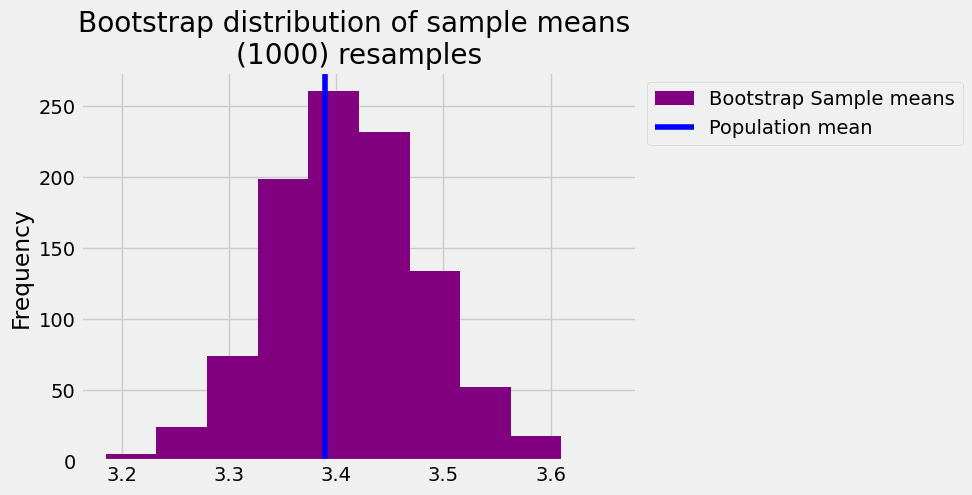

In [21]:
# a new dataframe for the means, obtained via resampling
resampled_means = pd.DataFrame()
resampled_means['Bootstrap Sample means'] = bstrap_means

# plot the distribution of bootstrapped means
resampled_means.plot.hist(color = 'purple')

# show the population mean
plt.axvline(population_mean,  color='blue', label = 'Population mean')

# add title and labels to the plot
plt.title(f'Bootstrap distribution of sample means \n({number_of_bootstrap_resamples}) resamples')
plt.legend(bbox_to_anchor = (1, 1));

## Does the distribution of bootstrap sample means capture the population mean?

Does histogram of the resampled means sit firmly over
the blue line, and not just brush the linewith its tails? To answer this, we must
define "sit firmly". Let's take that to mean "the middle 95% of the resampled
means contains the blue line".

Here are the two ends of the "middle 95%" interval of resampled means:

In [22]:
left, right = np.percentile(bstrap_means, [2.5, 97.5])
print('Left:', left)
print('Right:', right)

Left: 3.27717616248
Right: 3.54374669904


Is the population mean of 3.39kg is between these two numbers, `left` and
`right`? We show the interval and the population mean on the histogram below.

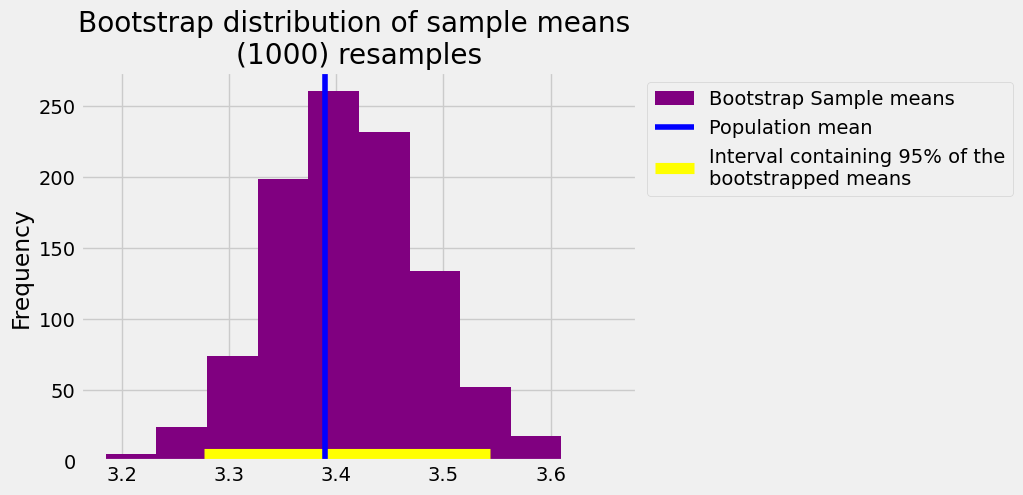

In [23]:
# show the boostrap resample distribution, its middle 95%, and the population mean
resampled_means.plot.hist(color = 'purple')
plt.axvline(population_mean,  color='blue', label = 'Population mean')
plt.plot([left, right], [5, 5], color='yellow', lw=8, zorder=1,
         label = "Interval containing 95% of the\nbootstrapped means")
plt.title(f'Bootstrap distribution of sample means \n({number_of_bootstrap_resamples}) resamples')
plt.legend(bbox_to_anchor = (1, 1));

To see how frequently the interval contains the parameter, we have to run the
entire process over and over again. Specifically, we will repeat the following
process 100 times:

* Draw an original sample of size 25 from the population.
* Carry out 1000 replications of the bootstrap process and generate the
  "middle 95%" interval of resampled means.

As usual we start by doing one trial, where we take one sample, and generate
one left and one right interval.  This is the code we have been using above.

We can run this cell manually many times, below will we automate this process:

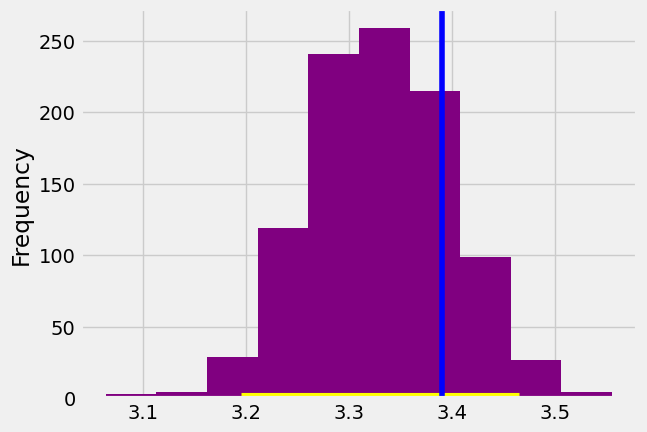

Left 3.1955578944000003
Left 3.4643396935200004


In [24]:
# One trial, generating a left and right interval.
# Take a new sample.
this_sample = babies_sample['birthweight_kg'].sample(25, replace=True)

# Get the bootstrap sampling distribution of the mean.
these_means = pd.Series(bootstrap_mean(this_sample, number_of_bootstrap_resamples))

these_means.plot.hist(color = 'purple', label = "Boostrap Sample means")
plt.axvline(population_mean,  color='blue', label = 'Population mean')

# Calculate the left, right ends, and plot them.
left_end, right_end = np.percentile(these_means, [2.5, 97.5])
plt.plot([left_end, right_end], [0, 0], color='yellow', lw=8, zorder=1,
         label = "Interval containing 95% of the\nbootstrapped means")

# add plot labels
plt.show()

# show the left and right end values
print('Left', left_end)
print('Left', right_end)

We will repeat this trial procedure 20 times, to give with 20 left and right
intervals, and count how many of these intervals contain the population mean.

**Spoiler alert:** The statistical theory of the bootstrap says that the number
should be around 95. It may be in the low 90s or high 90s, but not much farther
off 95 than that.

In [25]:
# THE BIG SIMULATION: This one can take several minutes.

# Set up to make 20 left and right intervals
n_intervals = 20
left_ends = np.zeros(n_intervals)
right_ends = np.zeros(n_intervals)

for i in np.arange(n_intervals):
    
    # One trial, generating a left and right interval.
    # Take a new sample.
    this_sample = babies_sample['birthweight_kg'].sample(25, replace=True)
    
    # Get the bootstrap sampling distribution of the mean.
    these_means = bootstrap_mean(this_sample, number_of_bootstrap_resamples)
    
    # Calculate the left, right ends.
    left_end, right_end = np.percentile(these_means, [2.5, 97.5])
    
    # Store the results for this trial.
    left_ends[i] = left_end
    right_ends[i] = right_end

# Put interval ends into own data frame.
intervals = pd.DataFrame()
intervals['Left'] = left_ends
intervals['Right'] = right_ends

For each of the 20 replications, we get one (left, right) interval of
estimates of the mean.

In [26]:
intervals

,Left,Right
0,3.180816,3.415579
1,3.231817,3.538020
2,3.279444,3.604982
3,3.260166,3.559622
4,3.257898,3.547092
5,3.272640,3.465445
6,3.395110,3.623069
7,3.280606,3.486991
8,3.214836,3.526709
9,3.321401,3.535780


The good intervals are those that contain the parameter we are trying to
estimate. Typically the parameter is unknown, but in this section we happen to
know what the parameter is.

In [27]:
population_mean

3.39

How many of the 20 intervals contain the population mean? That's the number
of intervals where the left end is below the population mean and the right
end is above.

In [28]:
intervals["Contains Population mean"] = np.logical_and(left_ends < population_mean, right_ends > population_mean)
intervals

,Left,Right,Contains Population mean
0,3.180816,3.415579,True
1,3.231817,3.538020,True
2,3.279444,3.604982,True
3,3.260166,3.559622,True
4,3.257898,3.547092,True
5,3.272640,3.465445,True
6,3.395110,3.623069,False
7,3.280606,3.486991,True
8,3.214836,3.526709,True
9,3.321401,3.535780,True


It takes a few minutes to construct all the intervals, but try it again if you
have the patience. Most likely, about 95% intervals will be good
ones: they will contain the parameter.

The graph below shows each interval on the same axes by stacking them
vertically. The vertical axis is simply the number of the replication from
which the interval was generated.

The blue line is where the parameter is. Good intervals cover the parameter;
about 95% of intervals generated by this method will be "good intervals", typically.

If an interval doesn't cover the parameter, it's a dud. The duds are the ones
where you can see "daylight" around the blue line. There are very few of them –
about 5% of them will be duds, typically – but they do happen.

Any method based on sampling has the possibility of being off. The beauty of
methods based on random sampling is that we can quantify how often they are
likely to be off.

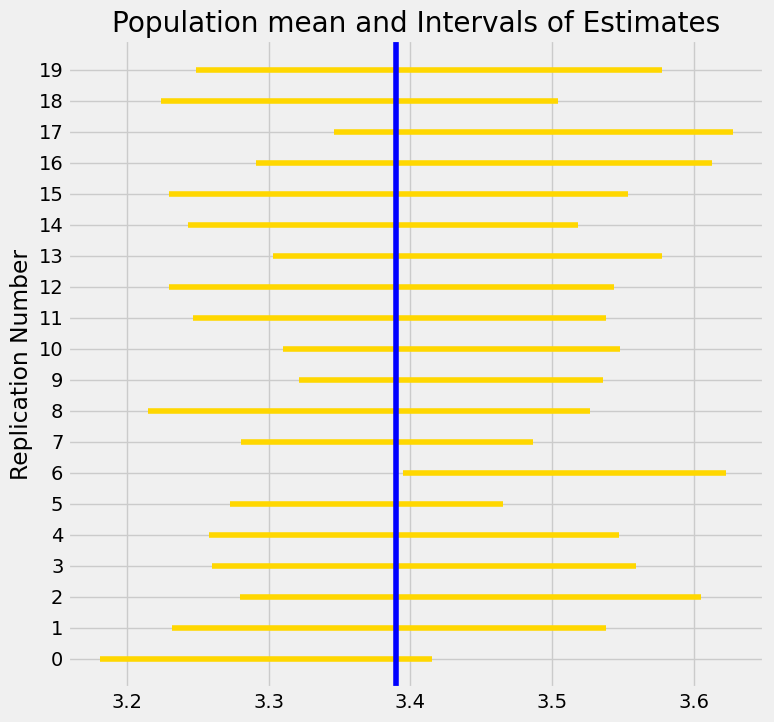

In [29]:
plt.figure(figsize=(8,8))
for i in np.arange(len(intervals)):
    ends = intervals[['Left', 'Right']].iloc[i]
    plt.plot(ends, [i, i], color='gold')
plt.axvline(population_mean,  color='blue', label = 'Population mean')
plt.plot([], [], color = 'gold',
         label = "Intervals containing 95% of the\nbootstrapped means for a given replication")
plt.ylabel('Replication Number')
plt.yticks(np.arange(n_intervals))
plt.title('Population mean and Intervals of Estimates');

To summarize what the simulation shows, suppose you are estimating the
population mean by the following process:

* Draw a large random sample from the population.
* Bootstrap your random sample and get an estimate from the new random sample.
* Repeat the above step thousands of times, and get thousands of estimates.
* Pick off the "middle 95%" interval of all the estimates.

That gives you one interval of estimates. Now if you repeat **the entire
process** 20 times, ending up with 20 intervals, then about 95% of those 20
intervals will contain the population parameter.

In other words, this process of estimation captures the parameter about 95% of
the time.

You can replace 95% by a different value, as long as it's not 100. Suppose you
replace 95% by 80% and keep the sample size fixed at 500. Then your intervals
of estimates will be shorter than those we simulated here, because the "middle
80%" is a smaller range than the "middle 95%". Only about 80% of your intervals
will contain the parameter.

*Note*: This page has content from the [Bootstrap](https://github.com/data-8/textbook/blob/64b20f0/notebooks/Bootstrap.ipynb)
notebook of an older version of the [UC Berkeley data science course](https://inferentialthinking.com/). See the Berkeley course section of the [license file](https://uob-ds.github.io/cfd2021/license).